In [7]:
import pandas as pd
def raw_session_based_clickstream_data():
  data = pd.read_csv("data.csv.csv")
  return data

In [8]:
raw_clickstream = raw_session_based_clickstream_data()
raw_clickstream.head(5)

,customer_id,customer_name,product_id_purchased,purchase_date_time,invoice_id
0,1,Gwendolyn Bennett,38,2023-12-16 12:51:24.424577,1
1,1,Gwendolyn Bennett,55,2023-08-25 09:24:06.204239,2
2,1,Gwendolyn Bennett,159,2023-03-13 00:22:21.464221,3
3,1,Gwendolyn Bennett,163,2023-03-14 12:33:18.670467,4
4,1,Gwendolyn Bennett,156,2022-08-19 01:20:06.083657,5


In [13]:
# remove consecutive duplicates from list
def remove_consec_duplicates(raw_lst):
  previous_value = None
  new_lst = []

  for elem in raw_lst:
    if elem != previous_value:
        new_lst.append(elem)
        previous_value = elem
        
  return new_lst


def generate_sequential_products():
  # Rename columns
  data = raw_clickstream.rename(columns={"customer_id": "customer_id", "product_id_purchased": "product_id"})
  # Remove sessions where only a single product is viewed
  data = data.groupby("customer_id").filter(lambda x: len(x) > 1)
  # Group product view sequences in order by session id
  data = data.sort_values("invoice_id").groupby("customer_id")["product_id"].apply(list)
  # Remove consecutive duplicate product views from the sequences genereated in the previous step
  data = data.apply(remove_consec_duplicates)

  #Convert series to data frame
  data = data.to_frame().reset_index().rename(columns={"product_id": "chronological_product_sequence"})

  return data

In [14]:
session_based_product_sequences = generate_sequential_products()
session_based_product_sequences.head(5)

,customer_id,chronological_product_sequence
0,1,"[38, 55, 159, 163, 156]"
1,2,"[134, 23, 133, 138, 199, 28]"
2,3,"[85, 43, 15, 59, 100, 56, 46]"
3,4,"[33, 27, 197, 156, 54]"
4,5,"[197, 153, 125, 134, 151, 53, 115, 144, 179]"


In [19]:
def create_product_embeddings():
  import gensim
  from gensim.models import Word2Vec  
  
  # Create Gensim CBOW model
  session_product_sequences = session_based_product_sequences['chronological_product_sequence'].apply(list)
  word2vec_model = gensim.models.Word2Vec(session_product_sequences, min_count = 1, vector_size = 10, window = 5)
  
  # numpy.ndarrays of product vectors
  product_vectors = word2vec_model.wv.vectors

  productID_list = word2vec_model.wv.key_to_index.keys()
  vector_list = word2vec_model.wv.vectors.tolist()
  data_tuples = list(zip(productID_list,vector_list))
  product_ids_and_vectors = pd.DataFrame(data_tuples, columns=['Product_ID','Vectors'])

  return product_ids_and_vectors

In [20]:
product_ids_and_vectors = create_product_embeddings()
product_ids_and_vectors.head(5)

,Product_ID,Vectors
0,97,"[0.2795741558074951, -0.31108370423316956, 0.5..."
1,167,"[0.39191102981567383, -0.29824715852737427, 0...."
2,17,"[0.36881765723228455, -0.26044341921806335, 0...."
3,16,"[0.19478288292884827, -0.26523691415786743, 0...."
4,153,"[0.26508399844169617, -0.2925524115562439, 0.4..."


In [21]:
def fit_kmeans():
  from sklearn.cluster import KMeans
  import numpy as np
  import matplotlib.pyplot as plt
  
  # Get product vectors from Word2Vec
  array_product_vectors = np.array(product_ids_and_vectors["Vectors"].values.tolist())

  # Fit K-Means algorithm on those embeddings
  kmeans_model = KMeans(n_clusters=10, random_state=0).fit(array_product_vectors)

  # Cluster Distribution Plot
  plot_cluster_distribution(kmeans_model)

  # Cluster Scatter Plot
  plot_cluster_scatter(array_product_vectors)
  
  return kmeans_model

def plot_cluster_distribution(kmeans_model):
  import matplotlib.pyplot as plt

  plt.hist(kmeans_model.labels_, rwidth=0.7)
  plt.ylabel("Number of Products")
  plt.xlabel("Cluster No")

  plt.show()

  # clear all plots and figures from memory
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()


def plot_cluster_scatter(product_vectors):
  import matplotlib.pyplot as plt
  from sklearn.decomposition import PCA
  from sklearn.cluster import KMeans
  import numpy as np

  pca = PCA(n_components=2)
  two_dimensions_vectors = pca.fit_transform(product_vectors)
  
  kmeans_model = KMeans(n_clusters=10, random_state=0).fit(two_dimensions_vectors)
  label = kmeans_model.fit_predict(two_dimensions_vectors)

  #Getting the Centroids
  centroids = kmeans_model.cluster_centers_
  u_labels = np.unique(kmeans_model.labels_)
  
  #plotting the results:
  for i in u_labels:
      plt.scatter(two_dimensions_vectors[label == i , 0] , two_dimensions_vectors[label == i , 1] , label = i)
  plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
  plt.legend(bbox_to_anchor =(1, 1))
  
  plt.show()

  # clear all plots and figures from memory
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()

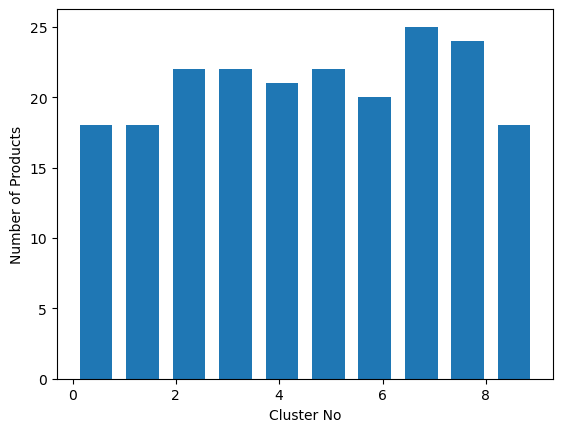

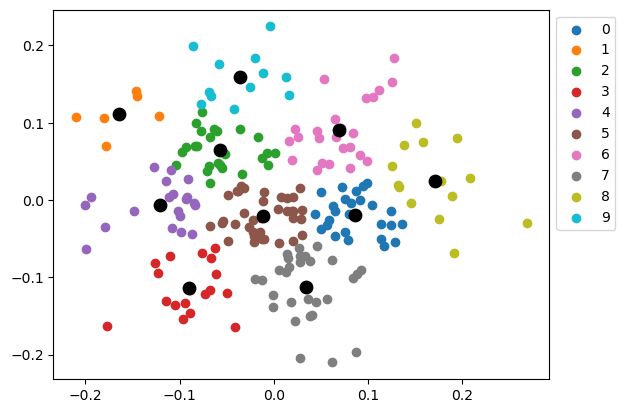

<Figure size 640x480 with 0 Axes>

In [22]:
model = fit_kmeans()

In [23]:
def save_final_product_clusters():
  import numpy as np  
  array_product_vectors = np.array(product_ids_and_vectors["Vectors"].values.tolist())

  assigned_cluster_no = model.fit_predict(array_product_vectors).tolist()

  product_ids_and_vectors["Cluster_No"] = assigned_cluster_no
  cluster_members_df = product_ids_and_vectors[["Product_ID","Cluster_No"]].groupby("Cluster_No")['Product_ID'].apply(list).to_frame().reset_index().rename(columns={'Product_ID': 'Cluster_Member_List'})

  return cluster_members_df

In [24]:
cluster_members_df = save_final_product_clusters()
cluster_members_df.head(10)

,Cluster_No,Cluster_Member_List
0,0,"[167, 116, 34, 109, 36, 135, 52, 196, 71, 20, ..."
1,1,"[160, 100, 26, 88, 15, 22, 81, 31, 126, 118, 6..."
2,2,"[149, 146, 32, 130, 193, 63, 7, 19, 123, 134, ..."
3,3,"[16, 95, 5, 62, 48, 59, 9, 148, 181, 189, 104,..."
4,4,"[97, 153, 158, 53, 82, 106, 46, 60, 136, 87, 1..."
5,5,"[17, 33, 195, 188, 49, 170, 168, 73, 84, 94, 1..."
6,6,"[108, 163, 180, 140, 175, 21, 38, 121, 190, 15..."
7,7,"[204, 206, 14, 147, 201, 67, 83, 98, 23, 171, ..."
8,8,"[207, 205, 120, 177, 133, 29, 110, 66, 200, 11..."
9,9,"[127, 159, 124, 210, 187, 1, 166, 13, 138, 129..."


In [33]:
import numpy as np
# Product ID to generate recommendations for - You could try different product IDs in the data such as A16, C17, P12 etc.
product_id = 97

# Get Vector (Embedding) array of the given product
vector_array = np.array(product_ids_and_vectors[product_ids_and_vectors["Product_ID"]==product_id]["Vectors"].tolist())

print(vector_array)
# Get cluster number for the given product assigned by the model
cluster_no = model.predict(vector_array.reshape(1, -1))[0]


# Get members list of the cluster that the given product is assigned to 
cluster_members_list = cluster_members_df[cluster_members_df['Cluster_No']==cluster_no]['Cluster_Member_List'].iloc[0]

# Randomly select 5 product recommendations from the cluster members excluding the given product
from random import sample
cluster_members_list.remove(product_id)
five_product_recommendations = sample(cluster_members_list, 5)

print("5 Similar Product Recommendations for {}: ".format(product_id),five_product_recommendations)

[[ 0.27957416 -0.3110837   0.55680829  0.48999745  0.02539519  0.37973505
   0.58304244  0.47899693 -0.34799394 -0.61449653]]
5 Similar Product Recommendations for 97:  [68, 53, 46, 122, 136]


In [34]:
# https://towardsdatascience.com/mlops-how-to-operationalise-e-commerce-product-recommendation-system-c755477bde5f